## Portfolio Project # 5
### Rohingya Refugees in Cox's Bazar, Bangladesh
### Exploring Rohingya Sentiments and Trending Topics with Twitter's API
##### https://developer.twitter.com/en/docs/twitter-api/tutorials

May 5, 2022

The initial goal for this project is to conduct analyses of sentiments and trending topics of Rohingya refugees in Bangladesh. Twitter granted my developer account elevated access to the Twitter API on 2021-12-20. If elevated access allows for filtering Tweets by geolocation, I will attempt to bound my analyses to the refugee camps and potentially to surrounding areas. Alternatively, I may use key hashtag terms: #Rohingya, #Rohingyas, Rohingya, Rohingyas. Scraped Tweets will be fed into Sentiment Analysis libraries (e.g. TextBlob or Vader Sentiment: https://github.com/cjhutto/vaderSentiment), Natural Language Processing libraries (e.g. NLTK: https://www.nltk.org/) or possibly TensorFlow. Currently, elevated access only allows searching for the past 7 days of Tweets.

Initial questions to explore: What are the current overall sentiments in the Rohingya refugee camps in Bangladesh? Are they positive or negative or neutral? What are currently the most frequently mentioned keywords or hashtags? Potential future questions to explore: What are the overall sentiments regarding biometric technologies (e.g. fingerprinting, iris scanning, ID cards etc)? How have they varied over time?

Skills: Python; MySQL; Twitter API; Tweepy; Pandas; Vader; NLTK; Matplotlib; Seaborn; Data Munging; Feature Engineering.

References for documentation and starter code:
<br>1. Getting started with the Twitter API v2 for academic research
<br>&emsp;&emsp; https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research
<br>2. A comprehensive guide for using the Twitter API v2 with Tweepy in Python
<br>&emsp;&emsp; https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9
<br>3. How to use the Twitter API v2 in Python using Tweepy
<br>&emsp;&emsp; https://www.youtube.com/watch?v=0EekpQBEP_8&t=758s
<br>4. Building queries for Search Tweets
<br>&emsp;&emsp; https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
<br>5. Twitter API v2 data dictionary
<br>&emsp;&emsp; https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet
<br>6. Introduction to Twitter data processing and storage on AWS
<br>&emsp;&emsp; https://dev.to/twitterdev/introduction-to-twitter-data-processing-and-storage-on-aws-1og
<br>7. A Complete Step by Step Tutorial on Sentiment Analysis in Keras and Tensorflow
<br>&emsp;&emsp; https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

Notes:
1. Searching for Tweets from the last 7 days
13. Keeping your dataset compliant
<br>https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/6b-labs-code-standard-python.md



In [1]:
# # Use datatable to speed up the process of loading data?
# import datatable as dt  # pip install datatable
# %%time
# tps_dt_october = dt.fread("data/train.csv").to_pandas()

### Script below to be run once on AWS to instantiate a MySQL database.

In [2]:
"""Using MySQL to practice deploying to the cloud with the idea that the database 
will grow every day and feed a website showing Rohingya Twitter metrics.
MySQL was chosen due to ease and widespread use. It is more efficient than pandas 
which is more computationally intensive to add rows to daily."""

import mysql.connector

In [3]:
import config    # Config file is used to keep passwords & keys for MySQL & Twitter.

mydb = mysql.connector.connect(
    host = config.HOST,
    user = config.USER,
    passwd = config.PASSWD,
    use_pure = True)

print(mydb)
db_cursor = mydb.cursor(buffered=True)
# Create database
db_cursor.execute("CREATE DATABASE Rohingya_tweets")

In [4]:
import os

host = os.getenv('MYSQL_HOST')
port = os.getenv('MYSQL_PORT')
user = os.getenv('MYSQL_USER')
password = os.getenv('MYSQL_PASSWORD')
database = os.getenv('MYSQL_DATABASE')

print(password)

None


In [5]:
mydb = mysql.connector.connect(
    host = config.HOST,
    user = config.USER,
    passwd = config.PASSWD,
    db = 'Rohingya_tweets',
    use_pure = True
)
print(mydb)
db_cursor = mydb.cursor(buffered=True)
#Create database table with date as primary key
db_cursor.execute("CREATE TABLE tweets(date DATE PRIMARY KEY, mentions INT(255))")
#Get database table
db_cursor.execute("SHOW TABLES")
for table in db_cursor:
    print(table)
db_cursor.close()

('tweets',)


True

### Script below to be run daily on AWS.

In [6]:
import tweepy
import config    # Config file is used to keep passwords & keys for MySQL & Twitter.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
client = tweepy.Client(bearer_token=config.BEARER_TOKEN)

In [8]:
query = '#Rohingya OR #Rohingyas OR Rohingya OR Rohingyas -is:retweet lang:en'

In [9]:
# This does not subtract from monthly tweet limit.
counts = client.get_recent_tweets_count(query=query, granularity='day')

In [10]:
# To check API payload:

# for count in counts.data:
#     print(count)

In [11]:
from datetime import datetime

dates = []
tweets = []
for count in counts.data:
    date = datetime.strptime(count['end'][:10], '%Y-%m-%d')
    # API payload includes 2 end dates for the current date with the 1st being the full day so the last date needs to be ignored.
    if date in dates:
        break
    else:
        dates.append(date)
        tweets.append(count['tweet_count'])
tups = tuple(zip(dates, tweets))
tups

((datetime.datetime(2022, 4, 30, 0, 0), 1928),
 (datetime.datetime(2022, 5, 1, 0, 0), 2803),
 (datetime.datetime(2022, 5, 2, 0, 0), 3121),
 (datetime.datetime(2022, 5, 3, 0, 0), 2538),
 (datetime.datetime(2022, 5, 4, 0, 0), 2236),
 (datetime.datetime(2022, 5, 5, 0, 0), 2159),
 (datetime.datetime(2022, 5, 6, 0, 0), 1711))

In [12]:
mydb = mysql.connector.connect(
    host = config.HOST,
    user = config.USER,
    passwd = config.PASSWD,
    db = 'Rohingya_tweets',
    use_pure = True
)
print(mydb)
db_cursor = mydb.cursor(buffered=True)

# Ignore adding dates that are already in the table:
for item in tups:
    tweets_sql_query = "INSERT IGNORE INTO tweets(date, mentions) VALUES('%s', %i)" %item
    db_cursor.execute(tweets_sql_query)
    mydb.commit()
print(db_cursor.rowcount, "Record Inserted")

1 Record Inserted


In [13]:
# Checking to see if insertions worked:

# db_cursor.execute("SELECT * FROM tweets")
# result = db_cursor.fetchall()
# for row in result:
#     print(row)

In [14]:
# Extracting the data from MySQL using pandas for visualizing:

df = pd.read_sql("SELECT * from tweets", mydb)
pd.set_option('display.expand_frame_repr', False)
db_cursor.close()
print(df)

         date  mentions
0  2022-04-30      1928
1  2022-05-01      2803
2  2022-05-02      3121
3  2022-05-03      2538
4  2022-05-04      2236
5  2022-05-05      2159
6  2022-05-06      1711


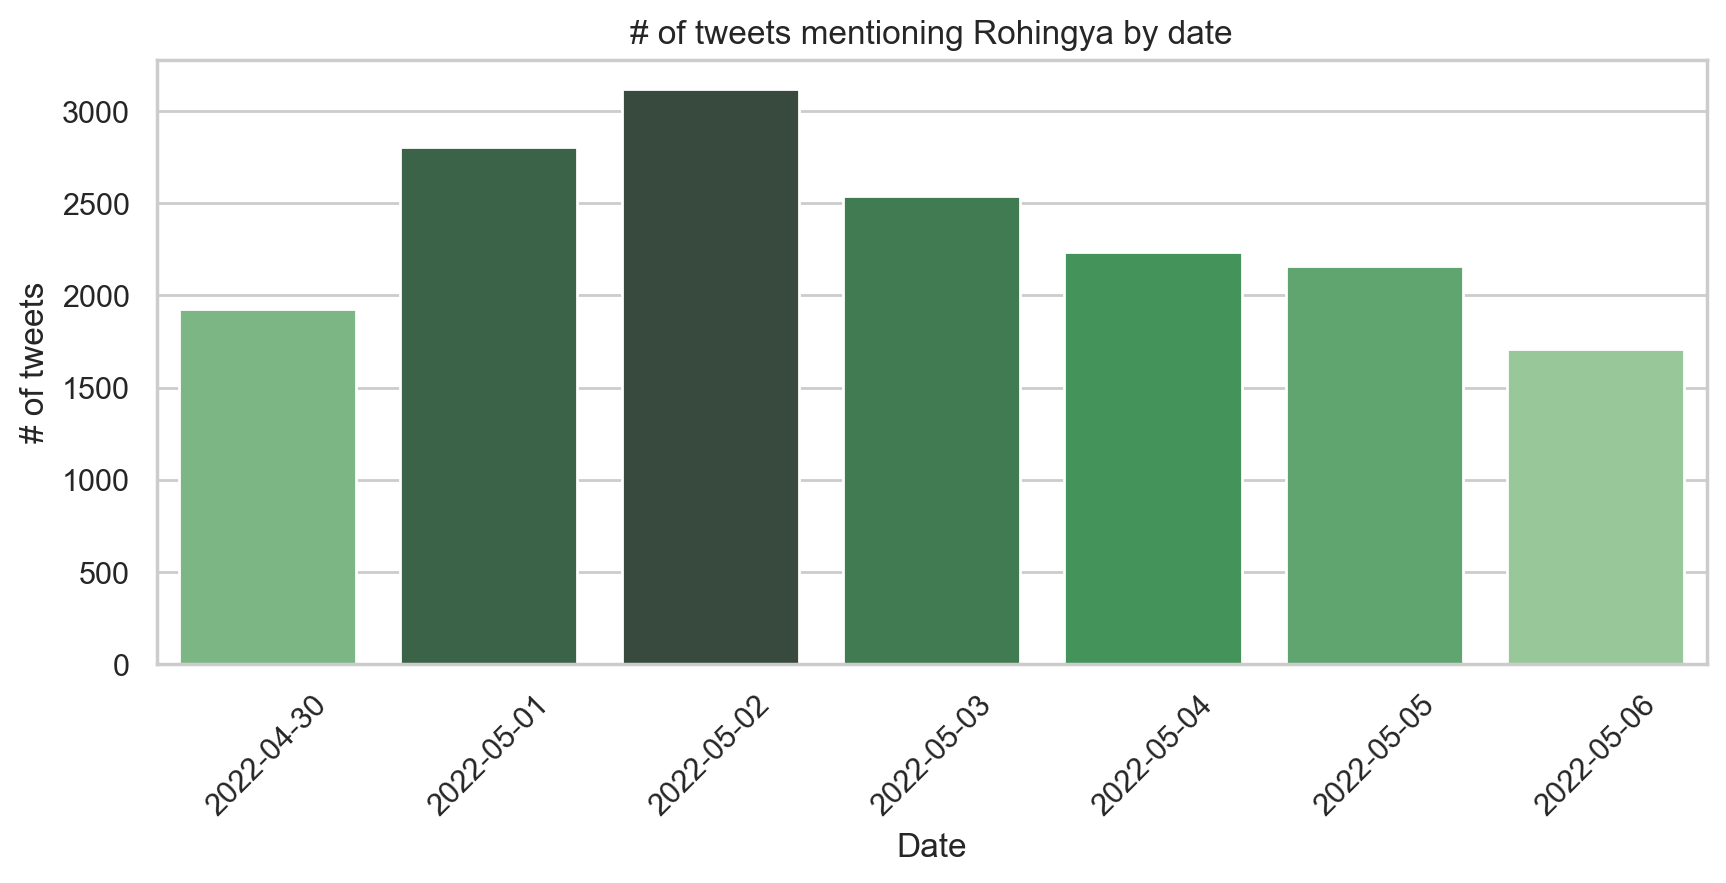

In [15]:
plt.figure(figsize=(10,4), dpi=200)

#  https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
sns.set(style="whitegrid", color_codes=True)
data = df['mentions']
pal = sns.color_palette("Greens_d", len(data))
rank = data.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
sns.barplot(x=df['date'], y=df['mentions'], palette=np.array(pal)[rank])

plt.title('# of tweets mentioning Rohingya by date')
plt.xlabel('Date')
plt.ylabel('# of tweets')
plt.xticks(rotation=45)
plt.savefig('tweets_count.png', bbox_inches='tight');

### Below cells are for querying and analyzing a tweets payload (in progress)

response = client.search_recent_tweets(query=query, max_results=10,
                                      tweet_fields=['author_id', 'id', 'text', 
                                                    'created_at', 'lang',
                                                    'geo', 'possibly_sensitive'])
# counts = client.get_recent_tweets_count(query=query, granularity='day')

df.loc[len(df)] = ['name5', 9, 0]

print(response)

for tweet in response.data:
    print(tweet.author_id)
    print(tweet.lang)
    print(tweet.created_at)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(data=response.data, columns=['author_id', 'id', 'text', 'created_at', 'lang',
                                               'geo', 'possibly_sensitive'])
df